In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Load data
data = pd.read_csv(r'C:\Users\OSAMA\anaconda_projects\My-Github\usa_housing_prices\dataset\usa_housing_prices.csv')
print(data.shape)
display(data.head())

(5000, 7)


,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


In [4]:
# Normalize column names
data.columns = data.columns.str.strip().str.lower().str.replace('.', '').str.replace(' ', '_')
print(data.columns.tolist())

['avg_area_income', 'avg_area_house_age', 'avg_area_number_of_rooms', 'avg_area_number_of_bedrooms', 'area_population', 'price', 'address']


In [5]:
# Quick EDA
print(data.info())

print('\nDescribe:')
display(data.describe().transpose())

print('\nMissing:')
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   avg_area_income              5000 non-null   float64
 1   avg_area_house_age           5000 non-null   float64
 2   avg_area_number_of_rooms     5000 non-null   float64
 3   avg_area_number_of_bedrooms  5000 non-null   float64
 4   area_population              5000 non-null   float64
 5   price                        5000 non-null   float64
 6   address                      5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB
None

Describe:


,count,mean,std,min,25%,50%,75%,max
avg_area_income,5000.0,6.858311e+04,10657.991214,17796.631190,61480.562390,6.880429e+04,7.578334e+04,1.077017e+05
avg_area_house_age,5000.0,5.977222e+00,0.991456,2.644304,5.322283,5.970429e+00,6.650808e+00,9.519088e+00
avg_area_number_of_rooms,5000.0,6.987792e+00,1.005833,3.236194,6.299250,7.002902e+00,7.665871e+00,1.075959e+01
avg_area_number_of_bedrooms,5000.0,3.981330e+00,1.234137,2.000000,3.140000,4.050000e+00,4.490000e+00,6.500000e+00
area_population,5000.0,3.616352e+04,9925.650114,172.610686,29403.928700,3.619941e+04,4.286129e+04,6.962171e+04
price,5000.0,1.232073e+06,353117.626584,15938.657920,997577.135075,1.232669e+06,1.471210e+06,2.469066e+06



Missing:
avg_area_income                0
avg_area_house_age             0
avg_area_number_of_rooms       0
avg_area_number_of_bedrooms    0
area_population                0
price                          0
address                        0
dtype: int64



Price summary:
count    5.000000e+03
mean     1.232073e+06
std      3.531176e+05
min      1.593866e+04
25%      9.975771e+05
50%      1.232669e+06
75%      1.471210e+06
max      2.469066e+06
Name: price, dtype: float64
skew: -0.0027180649317752378


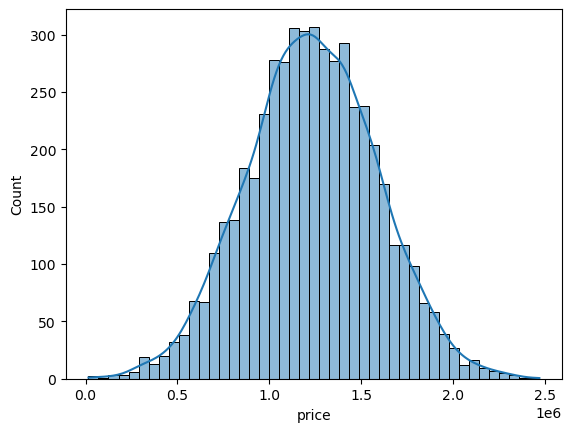

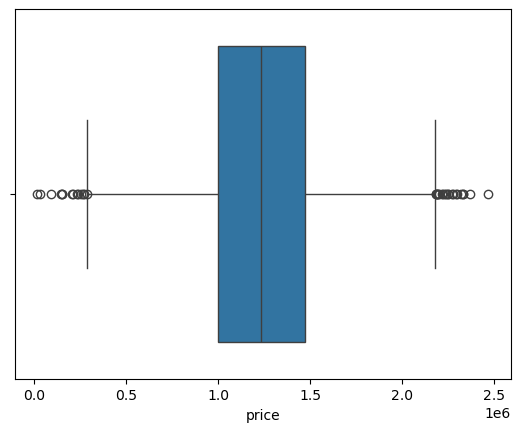


Top correlations with price:
price                          1.000000
avg_area_income                0.639734
avg_area_house_age             0.452543
area_population                0.408556
avg_area_number_of_rooms       0.335664
avg_area_number_of_bedrooms    0.171071
Name: price, dtype: float64


In [6]:
# Target checks
print('\nPrice summary:')
print(data['price'].describe())

# Skewness
print('skew:', data['price'].skew())

# Visualizations
sns.histplot(data['price'], kde=True); plt.show()
sns.boxplot(x=data['price']) 
plt.show()

# Correlations
print('\nTop correlations with price:')
print(data.select_dtypes(include=[np.number]).corr()['price'].sort_values(ascending=False).head(10))

In [7]:
# Feature engineering: extract state and drop address

def extract_state(addr):
    if pd.isna(addr):
        return np.nan
    m = re.search(r',\s*([A-Z]{2})\b', addr)
    if m:
        return m.group(1)
    parts = addr.split(',')
    return parts[-1].strip().split()[0] if len(parts)>1 else np.nan

if 'address' in data.columns:
    data['state'] = data['address'].apply(extract_state)
    data = data.drop(columns=['address'])

print(data[['state']].head(10))

  state
0    NE
1    CA
2    WI
3   NaN
4   NaN
5    KS
6    CO
7    TN
8   NaN
9   NaN


In [8]:
# Preprocessing: define X, y and simple transforms
TARGET = 'price'
X = data.drop(columns=[TARGET])
y = data[TARGET]
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
X[num_features] = X[num_features].fillna(X[num_features].median())


scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

if cat_features:
    X = pd.get_dummies(X, columns=cat_features, drop_first=True)

print('num:', num_features)
print('cat (after encoding):', [c for c in X.columns if c not in num_features])

num: ['avg_area_income', 'avg_area_house_age', 'avg_area_number_of_rooms', 'avg_area_number_of_bedrooms', 'area_population']
cat (after encoding): ['state_AL', 'state_AR', 'state_AS', 'state_AZ', 'state_Box', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_FM', 'state_GA', 'state_GU', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MH', 'state_MI', 'state_MN', 'state_MO', 'state_MP', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_PR', 'state_PW', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VI', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY']


In [13]:
X.head()

,avg_area_income,avg_area_house_age,avg_area_number_of_rooms,avg_area_number_of_bedrooms,area_population,state_AL,state_AR,state_AS,state_AZ,state_Box,...,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY
0,1.028660,-0.296927,0.021274,0.088062,-1.317599,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.000808,0.025902,-0.255506,-0.722301,0.403999,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.684629,-0.112303,1.516243,0.930840,0.072410,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,-0.491499,1.221572,-1.393077,-0.584540,-0.186734,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.807073,-0.944834,0.846742,0.201513,-0.988387,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# Split
a = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = a
print(X_train.shape, X_test.shape)

(4000, 64) (1000, 64)


In [11]:
# Train models and evaluate
lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)

def metrics(y_true,y_pred):
    return {
        'mae': mean_absolute_error(y_true,y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true,y_pred)),
        'r2': r2_score(y_true,y_pred)
    }

# Simple Decision Tree (no GridSearch)
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_dt = dt.predict(X_test)

# GridSearch example (uncomment to run)
# dt = DecisionTreeRegressor(random_state=42)
# param_grid = {'max_depth':[3,5,7,None], 'min_samples_leaf':[1,3,5,10]}
# gs = GridSearchCV(dt, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
# gs.fit(X_train, y_train)
# best_dt = gs.best_estimator_
# print('best', gs.best_params_)

# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('LR metrics:', metrics(y_test, y_lr))
print(f"LR MAPE: {mape(y_test, y_lr):.2f}%")

print('DT metrics:', metrics(y_test, y_dt))
print(f"DT MAPE: {mape(y_test, y_dt):.2f}%")

# If a tuned Decision Tree is available, show its metrics
try:
    y_best = best_dt.predict(X_test)
    print('Best DT metrics:', metrics(y_test, y_best))
    print(f"Best DT MAPE: {mape(y_test, y_best):.2f}%")
except Exception:
    pass


LR metrics: {'mae': 81913.30755562622, 'rmse': 101299.08572651687, 'r2': 0.9165951384351909}
LR MAPE: 7.49%
DT metrics: {'mae': 139013.8457071, 'rmse': 176392.67094810304, 'r2': 0.7471043336300096}
DT MAPE: 12.99%
